### General libraries being loaded

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Our new Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# For plotting statistical figures
import seaborn as sns; sns.set()

# For speeding up numpy operations
import cupy as cp

# For faster numpy computation
from numba import jit, cuda

# For Progress Bar
from tqdm.auto import tqdm,trange
tqdm.pandas()

# Vaex Dataframe library
import vaex as vx

# For Pyspark activation
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# Pyspark Dataframe
from pyspark import pandas as ps

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Training and Testing Data Loading

In [2]:
quora_tt_df = pd.read_pickle(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\quora_tt_df.pkl")
quora_tt_freq_df = pd.read_pickle(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\quora_tt_freq_df.pkl")

In [3]:
import pickle

f = open(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\quora_tt_dict_idf.pkl","rb")
f1 = open(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\quora_tt_word_dict.pkl","rb")

quora_tt_dict_idf = pickle.load(f)
quora_tt_word_dict = pickle.load(f1)

f.close()
f1.close()

max_sentence_length_quora = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\Data\Train and Test\max_sentence_length_quora.npy")
max_sentence_length_quora = int(max_sentence_length_quora)

### Glove Word Embedding Loading

In [4]:
glove_embedding_matrix_tt = np.load(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\glove.840B.300d\glove_embedding_matrix_tt.npy")

In [5]:
f = open(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\glove.840B.300d\glove_embedding_matrix_tt_dict.pkl","rb")
glove_embedding_matrix_tt_dict = pickle.load(f)
f.close()

### Basic imports for Model Execution

In [6]:
from keras.layers import Input,Embedding,SpatialDropout1D,Bidirectional,CuDNNLSTM,CuDNNGRU,GlobalMaxPooling1D,Concatenate,Dense,LSTM,GRU
from keras.optimizers import Adam
from keras.models import Model
from keras.initializers import Constant

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve

from kneed import KneeLocator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

### Creating a Deep Neural Network for Glove Word Embedding

In [7]:
def quora_DNN_build_model(embedding_matrix_quora,max_sentence_length_quora,embedding_size_quora,number_words_quora,learning_rate_quora):
    inp = Input(shape=(max_sentence_length_quora,))
    x = Embedding(number_words_quora, embedding_size_quora, embeddings_initializer=Constant(embedding_matrix_quora), trainable=False)(inp)
    x = SpatialDropout1D(0.3)(x)
    x1 = Bidirectional(LSTM(256, return_sequences=True))(x)
    x2 = Bidirectional(GRU(128, return_sequences=True))(x1)
    max_pool1 = GlobalMaxPooling1D()(x1)
    max_pool2 = GlobalMaxPooling1D()(x2)
    conc = Concatenate()([max_pool1, max_pool2])
    predictions = Dense(1, activation='sigmoid')(conc)
    model = Model(inputs=inp, outputs=predictions)
    adam = Adam(learning_rate=learning_rate_quora)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model_glove = quora_DNN_build_model(embedding_matrix_quora=glove_embedding_matrix_tt,max_sentence_length_quora=max_sentence_length_quora,
                             embedding_size_quora=300,number_words_quora=glove_embedding_matrix_tt.shape[0],learning_rate_quora=0.001)

In [9]:
num_epoch = 4
batch_size = 256

In [10]:
quora_train_features_array_glove = np.copy(np.array(quora_tt_df.loc[~(quora_tt_df['target'] == -1),'question_text_encode'].to_list(),dtype=np.float64))
quora_train_pridiction_array_glove = np.copy(np.array(quora_tt_df.loc[~(quora_tt_df['target'] == -1),'target'].to_list(),dtype=np.float64))
glove_history = model_glove.fit(quora_train_features_array_glove, quora_train_pridiction_array_glove, validation_split=0.2, batch_size=batch_size, validation_batch_size=batch_size, epochs=num_epoch-1, verbose=1, shuffle=True, use_multiprocessing=True)

Epoch 1/3
4082/4082 [==============================] - 748s 181ms/step - loss: 0.1130 - accuracy: 0.9555 - val_loss: 0.1025 - val_accuracy: 0.9589
Epoch 2/3
4082/4082 [==============================] - 735s 180ms/step - loss: 0.0993 - accuracy: 0.9605 - val_loss: 0.0974 - val_accuracy: 0.9611
Epoch 3/3
4082/4082 [==============================] - 738s 181ms/step - loss: 0.0929 - accuracy: 0.9628 - val_loss: 0.0975 - val_accuracy: 0.9607


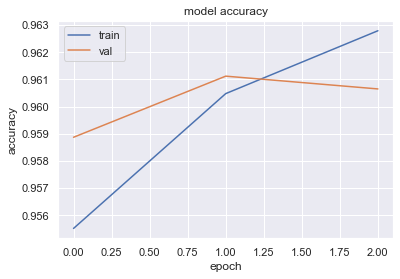

In [11]:
# Accuracy Plot
plt.plot(glove_history.history['accuracy'])
plt.plot(glove_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

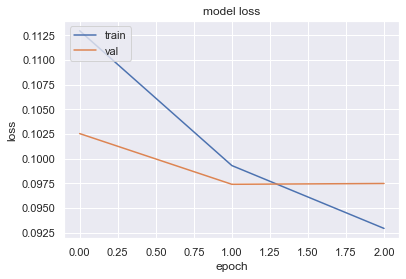

In [12]:
# Loss plot
plt.plot(glove_history.history['loss'])
plt.plot(glove_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
quora_train_pridicted_array_glove = model_glove.predict(quora_train_features_array_glove, batch_size=batch_size, verbose=1, use_multiprocessing=True)
quora_train_pridicted_array_glove = np.squeeze(quora_train_pridicted_array_glove)
quora_train_pridicted_array_glove_copy = np.copy(quora_train_pridicted_array_glove)

5103/5103 [==============================] - 297s 58ms/step


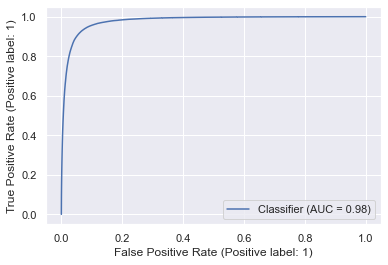

In [14]:
RocCurveDisplay.from_predictions(quora_train_pridiction_array_glove, quora_train_pridicted_array_glove)
plt.show()
fpr_glove, tpr_glove, thresholds_glove = roc_curve(quora_train_pridiction_array_glove, quora_train_pridicted_array_glove)

The Knee point of ROC Curve (x-axis) is:

0.02236654827505158


The Knee point of ROC Curve (y-axis) is:

0.7773914119539661




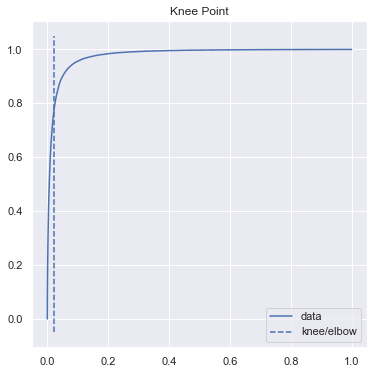

In [15]:
kn_glove = KneeLocator(fpr_glove, tpr_glove, curve='concave', direction='increasing')
print('\033[1m' + 'The Knee point of ROC Curve (x-axis) is:' + '\033[0m' + '\n')
print(kn_glove.knee)
print('\n')
print('\033[1m' + 'The Knee point of ROC Curve (y-axis) is:' + '\033[0m' + '\n')
print(kn_glove.knee_y)
print('\n')
kn_glove.plot_knee()

In [16]:
point_x_index_glove = np.where(fpr_glove == kn_glove.knee)
point_y_index_glove = np.where(tpr_glove == kn_glove.knee_y)
threshold_index_glove = np.intersect1d(point_x_index_glove, point_y_index_glove)
threshold_value_glove = thresholds_glove[threshold_index_glove[0]]

In [17]:
quora_train_pridicted_array_glove[quora_train_pridicted_array_glove <= threshold_value_glove] = 0
quora_train_pridicted_array_glove[quora_train_pridicted_array_glove > threshold_value_glove] = 1

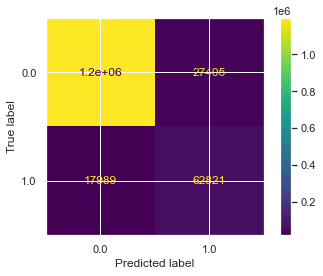

The Precision (Glove) is:

0.9673282296224022


The Recall (Glove) is:

0.9652452068030398


The F-Score (Glove) is:

0.9661348535805367




In [18]:
tn_glove, fp_glove, fn_glove, tp_glove = confusion_matrix(quora_train_pridiction_array_glove,quora_train_pridicted_array_glove).ravel()
ConfusionMatrixDisplay.from_predictions(quora_train_pridiction_array_glove,quora_train_pridicted_array_glove)
plt.show()

precision_glove, recall_glove, fbeta_score_glove, support_glove = precision_recall_fscore_support(quora_train_pridiction_array_glove,quora_train_pridicted_array_glove, average='weighted')
print('\033[1m' + 'The Precision (Glove) is:' + '\033[0m' + '\n')
print(precision_glove)
print('\n')
print('\033[1m' + 'The Recall (Glove) is:' + '\033[0m' + '\n')
print(recall_glove)
print('\n')
print('\033[1m' + 'The F-Score (Glove) is:' + '\033[0m' + '\n')
print(fbeta_score_glove)
print('\n')

In [19]:
quora_test_features_array_glove = np.copy(np.array(quora_tt_df.loc[(quora_tt_df['target'] == -1),'question_text_encode'].to_list(),dtype=np.float64))
quora_test_pridicted_array_glove = model_glove.predict(quora_test_features_array_glove, batch_size=batch_size, verbose=1, use_multiprocessing=True)
quora_test_pridicted_array_glove = np.squeeze(quora_test_pridicted_array_glove)

1468/1468 [==============================] - 86s 58ms/step


In [20]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [21]:
del glove_embedding_matrix_tt
del quora_train_features_array_glove
del quora_train_pridiction_array_glove
del model_glove

In [22]:
import gc
gc.collect()
print('',end='')

In [23]:
np.save(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\glove.840B.300d\quora_test_pridicted_array_glove.npy",quora_test_pridicted_array_glove)

In [24]:
del quora_test_pridicted_array_glove

In [25]:
np.save(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\glove.840B.300d\quora_train_pridicted_array_glove.npy",quora_train_pridicted_array_glove_copy)

In [26]:
del quora_train_pridicted_array_glove_copy
del quora_train_pridicted_array_glove

In [27]:
np.save(r"D:\UoA\Tri 2\Big Data Analysis and Projects\Week 1\Quora Insincere Questions\embeddings\glove.840B.300d\threshold_value_glove.npy",threshold_value_glove)